#  This script is written for preprocess EEG, EMG for RJ paradigm (both iMC and iVC are included) iVC: isokinetic/isovelocity contraction. This scripts is organized as follows: iMC prep from a to z then the synthesized function. iVC prep fcs are provided elsewhere

##  EMG processing: filtering low-pass: 200Hz, down sampling to 500Hz, then high pass 10 Hz
##  Reason: filter before downsampling to mitigate the distortion caused by aliasing. If a discrete-time signal's baseband spectral support is not limited to an interval of width 2 π / M radians, downsampling by M results in aliasing. 
## Link: https://dsp.stackexchange.com/questions/31843/aliasing-after-downsampling

## Specification of customization (things have to be changed):
- contraction_type can be either 'iMC' or 'iVC'
- session_idx for iMC is 's01' (pre-TMS) and 's02' (after-TMS), for iVC can be 's01' to 's06' with 's01'-'s03' prior to TMS
- please note that in official data processing, each subject can have only iMC or iVC data

## The pipeline for eeg preprocessing is
- alignment (crop the data before the onset of EMG recording)
- visually spot bad channels
- (to be discussed) whether to use 0.5hz high-pass, in my opinion, the 0.5hz is essencial to get rid of slow drift before thresholding. This is changed to 1-45Hz (avoid noises)
- baseline crop - for surrogeate data
- epoching and thresholding
- ICA fitting and exclusion

## The pipeline for emg prep
- alignment
- 10-200Hz band-pass filter
- epoch, resample


## Data integration

## Some notes for implementation:
- during iMC, the event markers is right after the onset of biometrics, and we select 18 second out of contraction phrase (20s) as validated data.  
- Things to be done: MI part (processing part to see the effect) - the report part, the function part

## Validation check and Special treatment
- validated iMC: subj02,04,10,14,15,17,18,19
- subj10: s01: session_duration = 39, deleted epochs :9,44; s02: session_duration = 39 deleted epochs: 18,19,29,30,31,32,41,42,43,44
- subj4: fourth trial of iMC is contaminated, deleted epochs: 27-35
- subj14: deleted epochs: 0,1,9,10,21,22
- subj17: deleted epochs: 21,22
- subj18: deleted epochs: 21
- subj19: deleted epochs: 21
- subj20: emg does not have the same length of eeg, eeg was cut before integration (cut to 230s)
- subj21: deleted epochs: 9,25,26,40,41, 1-41 bandP
- subj25: s01:session_duration = 48
- subj30: s01: srg:20-38.001, data length:raw_emg.crop(tmax = 246), s02: srg: 112-132, deleted epochs:11,12,17,41
- subj32: s02: srg 12-32.001, duration = 49, deleted epoch:22, s02: default
- subj34: s02: srg:51-71.001
- subj35: s01: deleted epochs: 13,14,21, emg6 is bad. s02: deleted epochs: 20,21

# Step 0: Global definition
The dict and relating script should be update/rerun every time the user spot a bad channel

In [252]:
bad_eeg_chs = {'2':
               {'iMC':{'s01':['T8','C3','CP6'],'s02':[]},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
               '3':
               {'iMC':{'s01':[],'s02':[]},
                'iVC':{'s01':['T8','T7'],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
                '4':
               {'iMC':{'s01':['Pz','T8'],'s02':['T8']},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
               '6':
               {'iMC':{'s01':[],'s02':[]},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
                '10':
               {'iMC':{'s01':[],'s02':[]},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
               '14':
               {'iMC':{'s01':[],'s02':[]},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
               '15':
               {'iMC':{'s01':['T8'],'s02':[]},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
               '16':
               {'iMC':{'s01':[],'s02':[]},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
               '17':
               {'iMC':{'s01':[],'s02':[]},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
               '18':
               {'iMC':{'s01':[],'s02':[]},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
               '19':
               {'iMC':{'s01':[],'s02':[]},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
               '20':
               {'iMC':{'s01':[],'s02':[]},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
               '21':
               {'iMC':{'s01':['PO4','F4'],'s02':[]},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
               '24':
               {'iMC':{'s01':['FC6'],'s02':[]},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
               '25':
               {'iMC':{'s01':[],'s02':[]},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
               '30':
               {'iMC':{'s01':['C4','PO4'],'s02':[]},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
               '32':
               {'iMC':{'s01':['Fz','T8'],'s02':[]},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
               '34':
               {'iMC':{'s01':['PO3'],'s02':['PO3','CP6','P3']},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
               '35':
               {'iMC':{'s01':['PO3'],'s02':['PO3']},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               }
              }
ICs2remove = {'2':
               {'iMC':{'s01':[8],'s02':[]},
                'iVC_push':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'iVC_pull':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
               },
              '3':
               {'iMC':{'s01':[],'s02':[]},
                'iVC_push':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'iVC_pull':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
               },
                '4':
               {'iMC':{'s01':[0,2],'s02':[0]},
                'iVC_push':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'iVC_pull':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
               },
               '6':
               {'iMC':{'s01':[],'s02':[]},
                'iVC_push':{'s01':[0,5],'s02':[0,1,5],'s03':[0,3,12],'s04':[0,1,7],'s05':[0,1],'s06':[0,5]},
                'iVC_pull':{'s01':[0],'s02':[0,1],'s03':[0],'s04':[0,1],'s05':[0],'s06':[0]},
               },
                '10':
               {'iMC':{'s01':[0,13],'s02':[0,2,15,16,17]},
                'iVC_push':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'iVC_pull':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'srg':{'iMC':{'s01':[0],'s02':[0,4,7]}}
               },
              '14':
               {'iMC':{'s01':[0,2,4],'s02':[]},
                'iVC_push':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'iVC_pull':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'srg':{'iMC':{'s01':[0,1,15],'s02':[]}}
               },
              '15':
               {'iMC':{'s01':[0,1],'s02':[]},
                'iVC_push':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'iVC_pull':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'srg':{'iMC':{'s01':[0,1,2],'s02':[]}}
               },
              '16':
               {'iMC':{'s01':[],'s02':[]},
                'iVC_push':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'iVC_pull':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
               },
              '17':
               {'iMC':{'s01':[1,6],'s02':[]},
                'iVC_push':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'iVC_pull':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'srg':{'iMC':{'s01':[0,5],'s02':[]}}
               },
              '18':
               {'iMC':{'s01':[0,1],'s02':[]},
                'iVC_push':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'iVC_pull':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'srg':{'iMC':{'s01':[0],'s02':[]}}
               },
              '19':
               {'iMC':{'s01':[0,1,7],'s02':[]},
                'iVC_push':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'iVC_pull':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'srg':{'iMC':{'s01':[1],'s02':[]}}
               },
              '20':
               {'iMC':{'s01':[0],'s02':[4,10]},
                'iVC_push':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'iVC_pull':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'srg':{'iMC':{'s01':[0,2],'s02':[]}}
               },
              '21':
               {'iMC':{'s01':[3,5,6,12],'s02':[]},
                'iVC_push':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'iVC_pull':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'srg':{'iMC':{'s01':[3,7],'s02':[0,1,7,13]}}
               },
              '24':
               {'iMC':{'s01':[2,3],'s02':[0,5]},
                'iVC_push':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'iVC_pull':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'srg':{'iMC':{'s01':[0,2],'s02':[0,1,2,3,4]}}
               },      
              '25':
               {'iMC':{'s01':[2,19],'s02':[6]},
                'iVC_push':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'iVC_pull':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'srg':{'iMC':{'s01':[],'s02':[1]}}
               },
              '30':
               {'iMC':{'s01':[0,1],'s02':[0,4]},
                'iVC_push':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'iVC_pull':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'srg':{'iMC':{'s01':[1,5],'s02':[6]}}
               },
              '32':
               {'iMC':{'s01':[1,10,11],'s02':[1,7]},
                'iVC_push':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'iVC_pull':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'srg':{'iMC':{'s01':[0,2],'s02':[0,2]}}
               },
              '34':
               {'iMC':{'s01':[1,2,3,14],'s02':[0,5,11,12]},
                'iVC_push':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'iVC_pull':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'srg':{'iMC':{'s01':[0,6],'s02':[0]}}
               },
              '35':
               {'iMC':{'s01':[0],'s02':[0,1]},
                'iVC_push':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'iVC_pull':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]},
                'srg':{'iMC':{'s01':[0,5],'s02':[0,3,4,6,9]}}
               }              
              }

# Step 1 : Visualization of EEG to spot bad channels
note that once the bad channels have been identified, you have to run this script twice to mark the bad channels
- current edition: take care of the .set and naming problem.

Used Annotations descriptions: ['1', 'empty']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (3.302 sec)



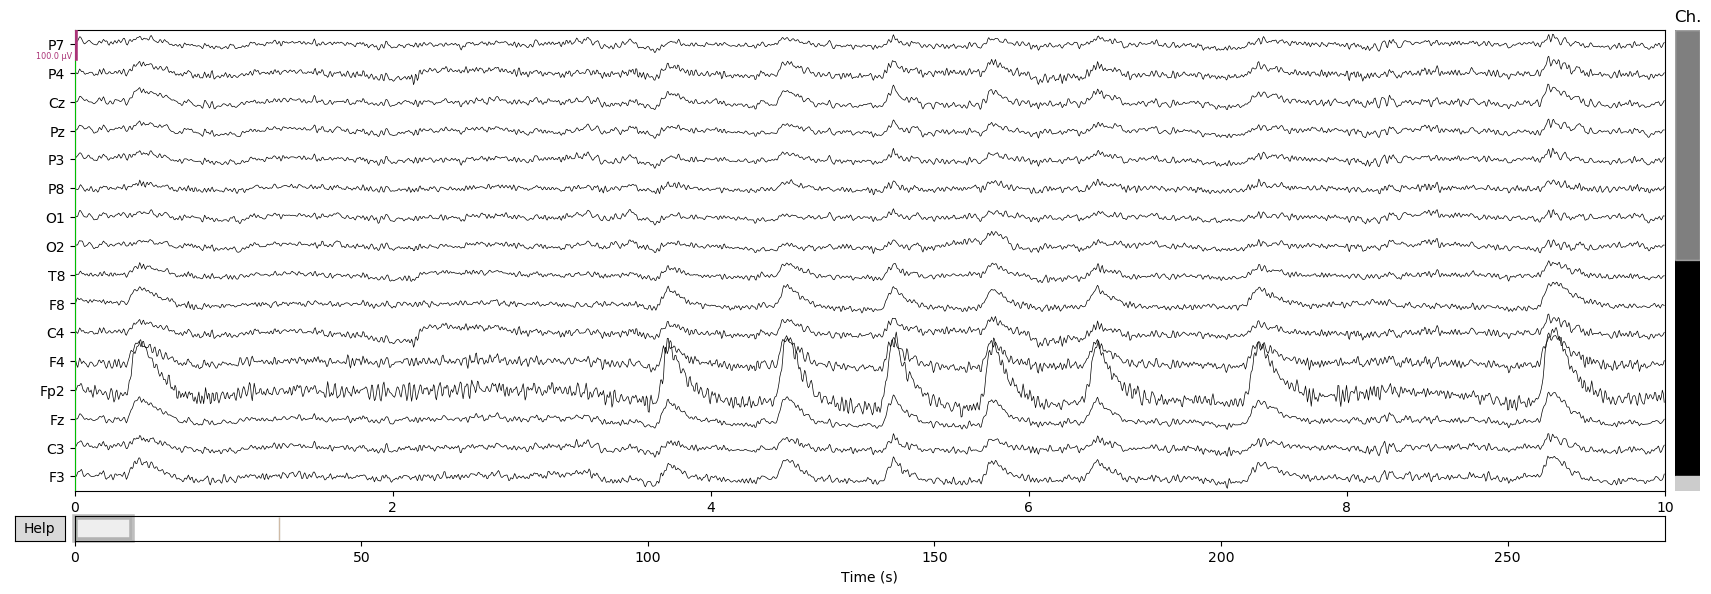

In [245]:
################## Import #####################
import os,mne,numpy as np, pandas as pd
from mne.preprocessing import ICA
%matplotlib qt
#############################################

################## Customization ##################
data_dir = 'D:/Data/MultiEEGEMG_stroke/'
subj_idx = '35'
contraction_type = 'iMC'
session_idx = 's02'
sfreq_emg=1000
sfreq_eeg=500
reject_criteria_eeg = dict(eeg=6e-4)       # 300 μV, do not exclude epochs containing ocular artifact
flat_criteria_eeg = dict(eeg=1e-6)           # 1 μV


################ fName
emg_fName = os.path.join(data_dir,'subj'+subj_idx,'EMG','subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'.txt')
eeg_fName = os.path.join(data_dir,'subj'+subj_idx,'EEG','subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'.set')
ica_dir = os.path.join(data_dir,'subj'+subj_idx,'ica')
epochs_beforeICA_dir = os.path.join(data_dir,'subj'+subj_idx,'epochs_beforeICA')
epochs_preped_dir = os.path.join(data_dir,'subj'+subj_idx,'epochs_preped')
epochs_hybrid_dir = os.path.join(data_dir,'subj'+subj_idx,'epochs_hybrid')
if not os.path.exists(ica_dir):
    os.makedirs(ica_dir)
if not os.path.exists(epochs_beforeICA_dir):
    os.makedirs(epochs_beforeICA_dir)
if not os.path.exists(epochs_preped_dir):
    os.makedirs(epochs_preped_dir)
if not os.path.exists(epochs_hybrid_dir):
    os.makedirs(epochs_hybrid_dir)
ica_fName = os.path.join(data_dir,'subj'+subj_idx,'ica','subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_ica.fif')
epochs_beforeICA_fName = os.path.join(data_dir,'subj'+subj_idx,'epochs_beforeICA',
                                      'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_beforeICA_epo.fif')
epochs_preped_fName = os.path.join(data_dir,'subj'+subj_idx,'epochs_preped',
                                      'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_preped_epo.fif')
epochs_hybrid_fName = os.path.join(data_dir,'subj'+subj_idx,'epochs_hybrid',
                                      'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_hybrid_epo.fif')
alignmentInfo_fName = os.path.join(data_dir,'subj'+subj_idx,'subj'+subj_idx+'_alignmentInfo.txt')
alignmentInfo = pd.read_csv(alignmentInfo_fName, skiprows=0,
                       sep = ',',engine = 'python')
############################################################

####### eeg reading ###########
raw_eeg = mne.io.read_raw_eeglab(eeg_fName,preload=True)
raw_eeg.set_montage('standard_1020')
events,events_id = mne.events_from_annotations (raw_eeg)
iMC_start = events[0][0]-alignmentInfo.loc[(alignmentInfo['sessionIdx']==session_idx) & 
                                      (alignmentInfo['contraction_type']==contraction_type),
                                      'EEG'].values[0]  #data point
raw_eeg.info['bads']=bad_eeg_chs[subj_idx][contraction_type][session_idx]
raw_eeg.crop(tmin = alignmentInfo.loc[(alignmentInfo['sessionIdx']==session_idx) & 
                                      (alignmentInfo['contraction_type']==contraction_type),
                                      'EEG'].values[0]/raw_eeg.info['sfreq'])
raw_eeg.filter(l_freq=1,h_freq=45)
########################################

raw_eeg.plot(scalings=dict(eeg=5e-5),duration = 10, n_channels = 16)

# Step 2.1 Baseline preprocessing for surrogates

In [246]:
from mne.preprocessing import read_ica 
# default parameters
# srg_tmin = 0.0
# srg_tmax = 20.001
srg_tmin = 0.0
srg_tmax = 20.001

raw_srg_dir = os.path.join(data_dir,'subj'+subj_idx,'raw_srg')
raw_srg_fName = os.path.join(raw_srg_dir,'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_srg_raw.fif')
eeg_srg_ica_fName = os.path.join(raw_srg_dir,'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_srg_eeg_ica.fif')
srg_ica_fName = os.path.join(raw_srg_dir,'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_srg_ica.fif')
raw_eeg_srg_beforeICA_fName = os.path.join(raw_srg_dir,
                                      'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_beforeICA_srg_eeg_raw.fif')
if not os.path.exists(raw_srg_dir):
    os.makedirs(raw_srg_dir)
    
############# emg reading ##############
ch_types = ['emg']*8
ch_names = []
for idx in range(8):
    ch_names.append('emg'+str(idx+1))
emg_data = pd.read_csv(emg_fName, header = None,skiprows=3, 
                       sep = ' ',usecols=np.arange(0,8),skipfooter=0,engine = 'python')
############### alignment 
emg_data= emg_data.iloc[alignmentInfo.loc[(alignmentInfo['sessionIdx']==session_idx) & 
                                      (alignmentInfo['contraction_type']==contraction_type),
                                      'EMG'].values[0]:,:].values
############## low-pass filter
emg_data=emg_data.T/1e6
emg_data = mne.filter.filter_data(emg_data,sfreq=1000,l_freq=10,h_freq=200)
############## epoch emg data
info = mne.create_info(ch_names=ch_names, sfreq=sfreq_emg, ch_types=ch_types)
raw_emg = mne.io.RawArray(emg_data, info)
# raw_emg.crop(tmax = 246)
raw_emg_srg = raw_emg.copy()
raw_emg_srg.crop(tmin = srg_tmin,tmax =srg_tmax)
raw_emg_srg.resample(sfreq=sfreq_eeg)

raw_eeg_srg = raw_eeg.copy()
raw_eeg_srg.crop(tmin = srg_tmin, tmax =srg_tmax)
ica = ICA(n_components = 0.99,random_state=97)
ica.fit(raw_eeg_srg)
raw_eeg_srg.save(raw_eeg_srg_beforeICA_fName,overwrite=True)
ica.save(srg_ica_fName)
ica = read_ica(srg_ica_fName)
raw_eeg_srg = mne.io.read_raw_fif(raw_eeg_srg_beforeICA_fName,preload=True)
ica.plot_sources(raw_eeg_srg,stop=10)
ica.plot_components(inst = raw_eeg_srg)

Setting up band-pass filter from 10 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 200.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 225.00 Hz)
- Filter length: 1321 samples (1.321 sec)

Creating RawArray with float64 data, n_channels=8, n_times=279999
    Range : 0 ... 279998 =      0.000 ...   279.998 secs
Ready.
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by explained variance: 12 components
Fitting ICA took 0.8s.
Writing D:\Data\MultiEEGEMG_stroke\subj35\raw_srg\subj35_iMC_s02_beforeICA_srg_eeg_raw.fif
Closing D:\Data\MultiEEGEMG_stroke\subj35\raw_srg\subj35_iMC

d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


[<Figure size 975x706.5 with 12 Axes>]

    Using multitaper spectrum estimation with 7 DPSS windows
10 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
10 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
10 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


# Step 2.2 ICA exclusion on surrogate data

Transforming to ICA space (12 components)
Zeroing out 5 ICA components
    Automatic origin fit: head of radius 91.4 mm
Computing interpolation matrix from 31 sensor positions
Interpolating 1 sensors
Writing D:\Data\MultiEEGEMG_stroke\subj35\raw_srg\subj35_iMC_s02_srg_raw.fif
Closing D:\Data\MultiEEGEMG_stroke\subj35\raw_srg\subj35_iMC_s02_srg_raw.fif [done]


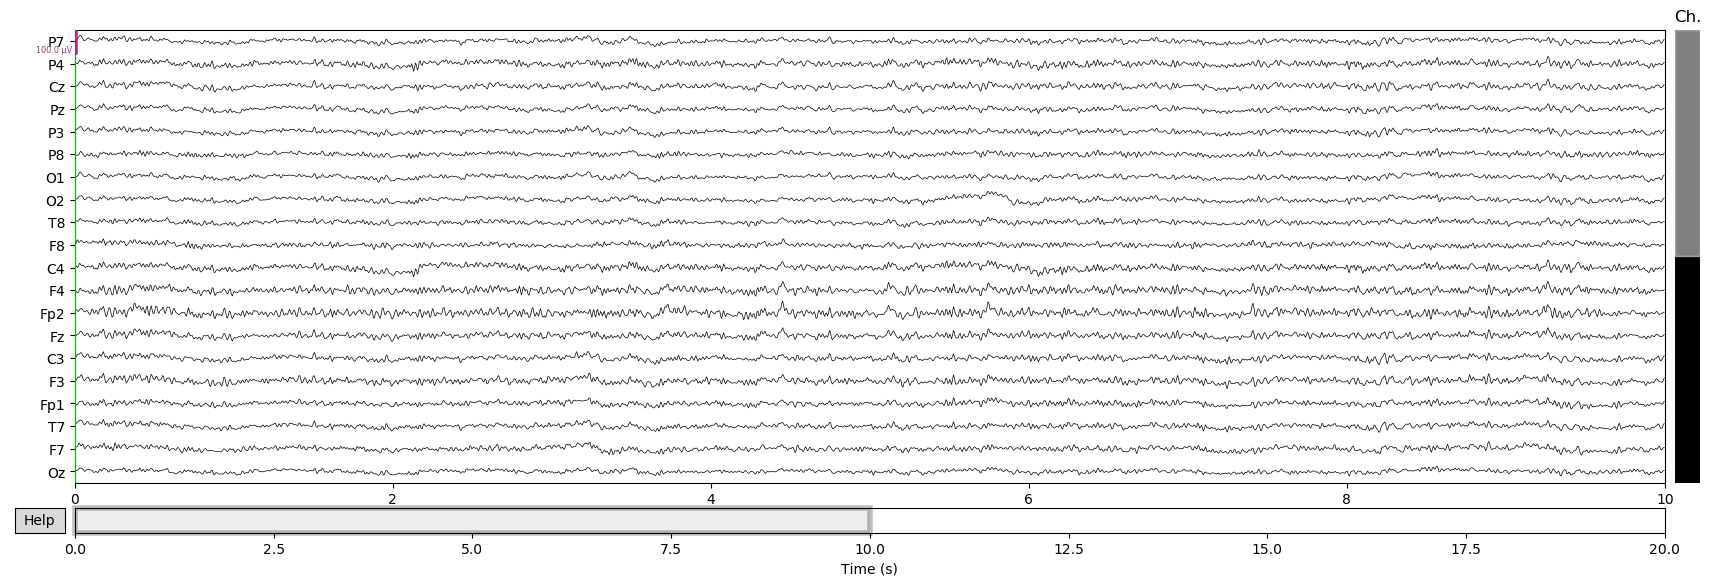

In [248]:
ica.exclude = ICs2remove[subj_idx]['srg'][contraction_type][session_idx]
raw_eeg_srg_preped = raw_eeg_srg.copy()
ica.apply(raw_eeg_srg_preped)
raw_eeg_srg_preped.interpolate_bads()
raw_emg_srg.info['highpass'] = raw_eeg_srg.info['highpass']
raw_emg_srg.info['lowpass'] = raw_eeg_srg.info['lowpass']
raw_srg = raw_eeg_srg_preped.add_channels([raw_emg_srg])
raw_srg.save(raw_srg_fName,overwrite=True)
raw_srg.plot(scalings = 5e-5,duration=10) #check baseline 

# Step 3: epoch eeg data (Motor) and fits ICA

In [249]:
###### epoching engineer ############
# default session_duration is 50 - susceptible
session_duration = 50
iMC_onsets = np.linspace(start = iMC_start/raw_eeg.info['sfreq']+2.5, 
                         stop = iMC_start/raw_eeg.info['sfreq']+2.5+session_duration*4,num=5)
iMC_2s_onsets = np.linspace(start = iMC_onsets,stop = iMC_onsets +18,endpoint=False,num=9) # Out of 18
iMC_2s_onsets = np.ravel(iMC_2s_onsets,order = 'F')
durations = [0.]*5*9
descriptions = ['onset_iMC']*5*9
annot = mne.Annotations(onset=iMC_2s_onsets, duration=durations,
                                    description=descriptions,
                                    orig_time=raw_eeg.info['meas_date'])
raw_eeg.set_annotations(annot)
#raw_eeg.plot()
events,events_id = mne.events_from_annotations (raw_eeg)
epochs_eeg = mne.Epochs(raw_eeg,events,reject=reject_criteria_eeg, 
                        flat=flat_criteria_eeg,tmin=0.0,tmax=2,baseline=(0, 0),preload=True)
################################################

############ ICA fitting ###############
ica = ICA(n_components = 0.99,random_state=97)
ica.fit(epochs_eeg)
epochs_eeg.save(epochs_beforeICA_fName,overwrite=True)
ica.save(ica_fName)
################################

Used Annotations descriptions: ['onset_iMC']
45 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 45 events and 1001 original time points ...
0 bad epochs dropped
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by explained variance: 14 components
Fitting ICA took 1.7s.
Writing ICA solution to D:/Data/MultiEEGEMG_stroke/subj35\ica\subj35_iMC_s02_ica.fif...


<ICA  |  epochs decomposition, fit (fastica): 45045 samples, 14 components, channels used: "eeg">

# Step 4: manual scrutization of ICA

In [250]:
############## ICA checking ############
from mne.preprocessing import read_ica
ica = read_ica(ica_fName)
epochs_eeg = mne.read_epochs(epochs_beforeICA_fName,preload=True)
ica.plot_sources(epochs_eeg,stop=4)
ica.plot_components(inst = epochs_eeg)
#########################################

Reading D:/Data/MultiEEGEMG_stroke/subj35\ica\subj35_iMC_s02_ica.fif ...
Now restoring ICA solution ...
Ready.
Reading D:/Data/MultiEEGEMG_stroke/subj35\epochs_beforeICA\subj35_iMC_s02_beforeICA_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
45 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


[<Figure size 975x706.5 with 14 Axes>]

    Using multitaper spectrum estimation with 7 DPSS windows
45 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
45 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\scipy\stats\_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\scipy\stats\_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
d:\software\1python3.75amd64\envs\eegemg\lib\site-packages\mne\viz\evoked.py:2285: RuntimeWarning: invalid value encountered in greater
  norm = np.all(allvalues > 0)


# Step 5: ICA exclusion

In [253]:
ica = read_ica(ica_fName)
epochs_eeg = mne.read_epochs(epochs_beforeICA_fName,preload=True)
ica.exclude = ICs2remove[subj_idx][contraction_type][session_idx]
epochs_preped = epochs_eeg.copy()
ica.apply(epochs_preped)
epochs_preped.interpolate_bads()
epochs_preped.save(epochs_preped_fName,overwrite=True)

Reading D:/Data/MultiEEGEMG_stroke/subj35\ica\subj35_iMC_s02_ica.fif ...
Now restoring ICA solution ...
Ready.
Reading D:/Data/MultiEEGEMG_stroke/subj35\epochs_beforeICA\subj35_iMC_s02_beforeICA_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
45 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Transforming to ICA space (14 components)
Zeroing out 2 ICA components
    Automatic origin fit: head of radius 91.4 mm
Computing interpolation matrix from 31 sensor positions
Interpolating 1 sensors


# Step 6: emg preprocessing and data integration 
Note: only the eeg filter and event information remains

In [254]:
############ get dropped epoch idx from eeg, then delete the onset        
epoch_idx = 0
bad_epochs_idx=[]
for i in epochs_eeg.drop_log:
    if i==[]:
        epoch_idx+=1
    else:
        bad_epochs_idx.append(epoch_idx)
        epoch_idx+=1
for idx in sorted(bad_epochs_idx,reverse=True):
    iMC_2s_onsets= np.delete(iMC_2s_onsets,idx) # no need to *2, since the iMC_2s_onsets is the time
durations = [0.]*len(iMC_2s_onsets)
descriptions = ['onset_iMC']*len(iMC_2s_onsets)
annot_emg = mne.Annotations(onset=iMC_2s_onsets, duration=durations,
                                    description=descriptions,
                                    orig_time=raw_emg.info['meas_date'])
raw_emg.set_annotations(annot_emg)
events,events_id = mne.events_from_annotations (raw_emg)
epochs_emg = mne.Epochs(raw_emg,events,tmin=0.0,tmax=2+1/1000,baseline=(0, 0),preload=True)
epochs_emg.resample(sfreq=sfreq_eeg)
####################################################

############## hybrid epoch #######################
epochs_emg.info['highpass'] = epochs_preped.info['highpass']
epochs_emg.info['lowpass'] = epochs_preped.info['lowpass']
epochs_preped.drop_bad()
epochs_emg.events = epochs_preped.events
epochs_hybrid = mne.epochs.add_channels_epochs([epochs_preped,epochs_emg])
epochs_hybrid.save(epochs_hybrid_fName,overwrite=True)

Used Annotations descriptions: ['onset_iMC']
45 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 45 events and 2002 original time points ...
0 bad epochs dropped


# Result validation

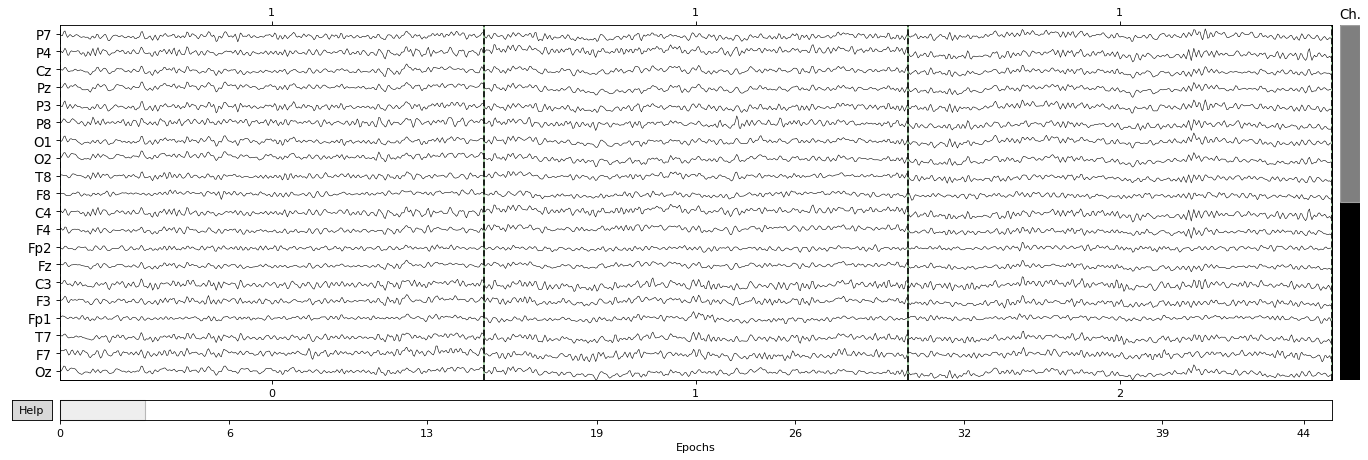

In [255]:
epochs_hybrid.plot(n_epochs=3,picks='all',scalings = 5e-5)

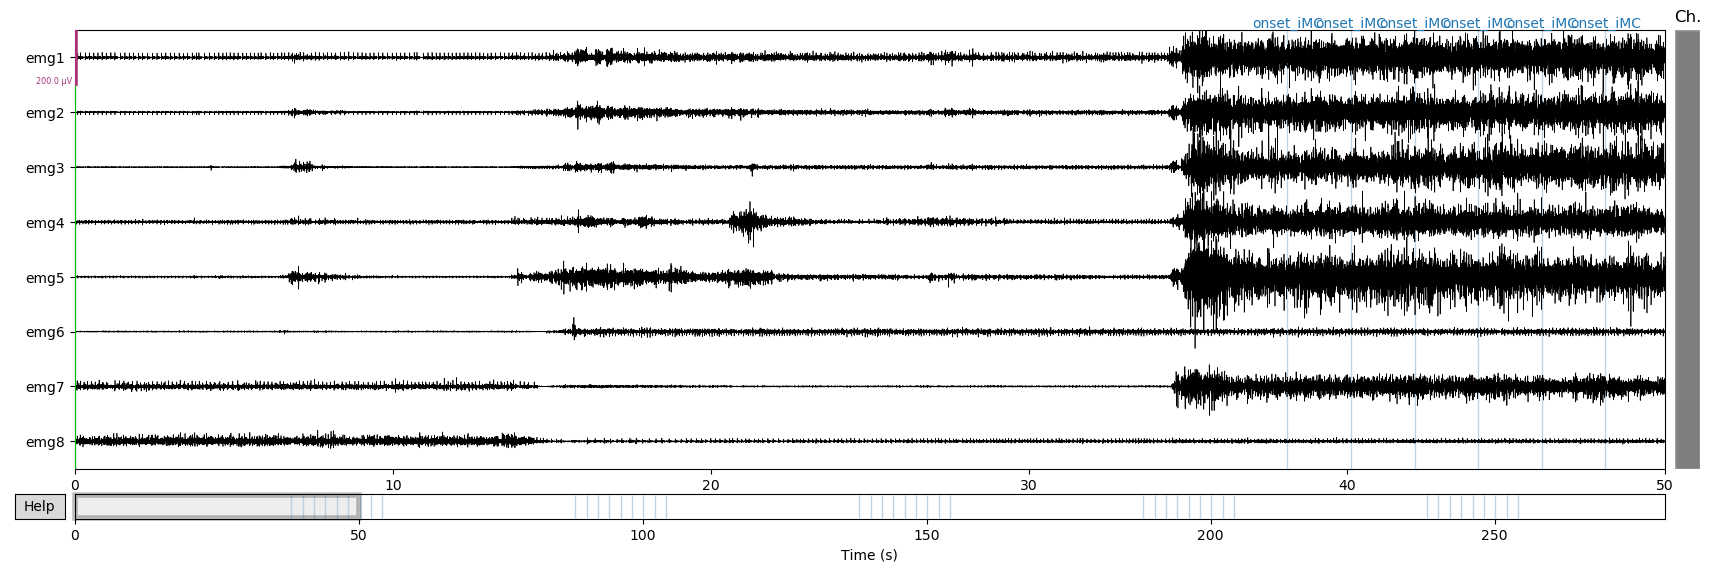

In [256]:
raw_emg.plot(scalings=1e-4,duration=50)

# Optional: Manual drop out of epochs_hybrid

In [257]:
epochs_hybrid.drop([20,21],reason = 'uncontracted')
epochs_hybrid.save(epochs_hybrid_fName,overwrite=True)

Overwriting existing file.


# End of prep scripts

In [196]:
#check EMG segmentation, after Step 2
emg_data = pd.read_csv(emg_fName, header = None,skiprows=3, 
                       sep = ' ',usecols=np.arange(0,8),skipfooter=0,engine = 'python')
emg_data= emg_data.iloc[alignmentInfo.loc[(alignmentInfo['sessionIdx']==session_idx) & 
                                      (alignmentInfo['contraction_type']==contraction_type),
                                      'EMG'].values[0]:,:].values
############## low-pass filter
emg_data=emg_data.T/1e6
emg_data = mne.filter.filter_data(emg_data,sfreq=1000,l_freq=10,h_freq=200)
############## epoch emg data
info = mne.create_info(ch_names=ch_names, sfreq=sfreq_emg, ch_types=ch_types)
raw_emg = mne.io.RawArray(emg_data, info)

epoch_idx = 0
bad_epochs_idx=[]
for i in epochs_eeg.drop_log:
    if i==[]:
        epoch_idx+=1
    else:
        bad_epochs_idx.append(epoch_idx)
        epoch_idx+=1
for idx in sorted(bad_epochs_idx,reverse=True):
    iMC_2s_onsets= np.delete(iMC_2s_onsets,idx) # no need to *2, since the iMC_2s_onsets is the time
durations = [0.]*len(iMC_2s_onsets)
descriptions = ['onset_iMC']*len(iMC_2s_onsets)
annot_emg = mne.Annotations(onset=iMC_2s_onsets, duration=durations,
                                    description=descriptions,
                                    orig_time=raw_emg.info['meas_date'])
raw_emg.set_annotations(annot_emg)

raw_emg.plot(scalings=1e-4,duration=50)
############ get dropped epoch idx from eeg, then delete the onset 

Setting up band-pass filter from 10 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 200.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 225.00 Hz)
- Filter length: 1321 samples (1.321 sec)

Creating RawArray with float64 data, n_channels=8, n_times=246582
    Range : 0 ... 246581 =      0.000 ...   246.581 secs
Ready.


IndexError: index 44 is out of bounds for axis 0 with size 43